# (30) Poisson? Gamma?

**Motivation**: The heck am I doing? <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Torch Poisson

In [94]:
from torch.distributions.poisson import Poisson

loss_fn = nn.L1Loss()

In [95]:
r = torch.tensor(
    data=[
        0.5, 1.0, 2.0, 5.0,
        10.0, 25.0, 100.0],
    requires_grad=True,
)

dist = Poisson(r)
# z = dist.sample()
z = r + (dist.sample() - r).detach()
x = z ** 2

loss = loss_fn(x, torch.zeros_like(x))
loss.backward()

In [99]:
z

tensor([  0.,   1.,   1.,   7.,  10.,  18., 107.], grad_fn=<AddBackward0>)

In [97]:
x.grad

/tmp/ipykernel_561578/3730140797.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/build/aten/src/ATen/core/TensorBody.h:486.)
  x.grad


In [98]:
r.grad

tensor([ 0.0000,  0.2857,  0.2857,  2.0000,  2.8571,  5.1429, 30.5714])

In [90]:
z

tensor([  0.,   0.,   4.,   3.,  11.,  28., 100.], grad_fn=<AddBackward0>)

In [91]:
x

tensor([0.0000e+00, 0.0000e+00, 1.6000e+01, 9.0000e+00, 1.2100e+02, 7.8400e+02,
        1.0000e+04], grad_fn=<PowBackward0>)

In [92]:
z.grad

/tmp/ipykernel_561578/4110045842.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/build/aten/src/ATen/core/TensorBody.h:486.)
  z.grad


In [93]:
x.grad

/tmp/ipykernel_561578/3730140797.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/build/aten/src/ATen/core/TensorBody.h:486.)
  x.grad


In [79]:
z

tensor([  0.,   0.,   2.,  10.,   9.,  34., 117.], grad_fn=<AddBackward0>)

In [48]:
r.requires_grad, z.requires_grad

(True, True)

In [49]:
r, z

(Parameter containing:
 tensor([  0.5000,   1.0000,   2.0000,   5.0000,  10.0000,  25.0000, 100.0000],
        requires_grad=True),
 tensor([ 0.,  2.,  1.,  4.,  3., 29., 92.], grad_fn=<AddBackward0>))

In [51]:
dist.log_prob(z)

tensor([-0.5000, -1.6931, -1.3069, -1.7403, -4.8840, -2.9096, -3.5096],
       grad_fn=<SubBackward0>)

In [56]:
r.grad

## Plot KL residual

In [2]:
def fun(x):
    return 1 - x * (1 - np.log(x))

dr = np.linspace(0, 5.5, 100001)[1:]
y = fun(dr)

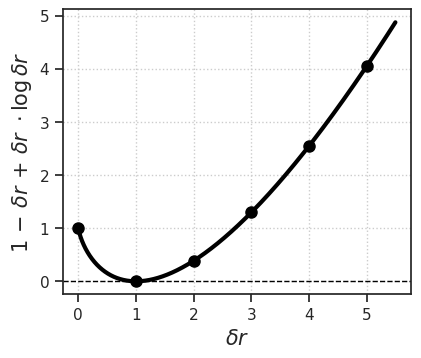

In [3]:
fig, ax = create_figure(1, 1, (4.5, 3.7))

ax.axhline(0, color='k', ls='--', lw=1.0)
ax.plot(dr, y, lw=3, color='k')
ax.grid()

ax.plot(0, 1, marker='o', color='k', markersize=8)
for i in range(1, 5 + 1):
    ax.plot(i, fun(i), marker='o', color='k', markersize=8)

ax.set_xlabel("$\delta r$", fontsize=15)
y_label = "$1 \, - \, \delta r \, + \, \delta r \,\,\cdot \log \delta r$"
# y_label = "$1 - \delta r \cdot (1 - \log \delta r)$"
ax.set_ylabel(y_label, fontsize=15)
fig.savefig(pjoin(fig_base_dir, 'poisson_residual.pdf'), bbox_inches='tight')
plt.show()

## Gamma approx.

In [4]:
lamb = 50
po = sp_stats.poisson(lamb)
ga = sp_stats.gamma(lamb, 0, 1)

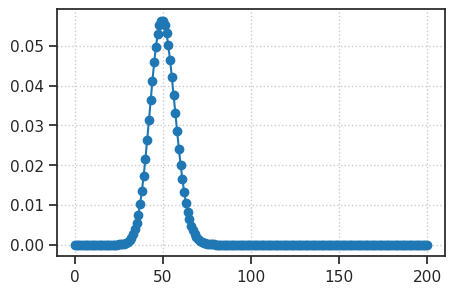

In [5]:
fig, ax = create_figure()
x = range(int(4 * lamb) + 1)
ax.plot(x, po.pmf(x), marker='o')
ax.grid()

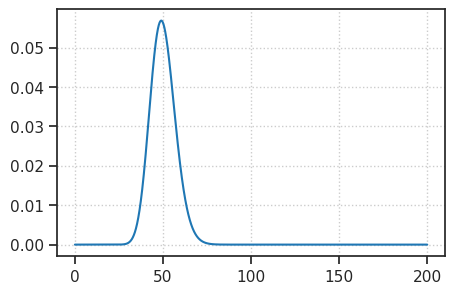

In [6]:
fig, ax = create_figure()
x = np.linspace(0, 4 * lamb, int(8 * lamb * 10) + 1)
ax.plot(x, ga.pdf(x), marker='none')
ax.grid()

In [7]:
rng = get_rng()

In [8]:
n = 100000
samples_ga = rng.gamma(lamb, 1.0, size=n)

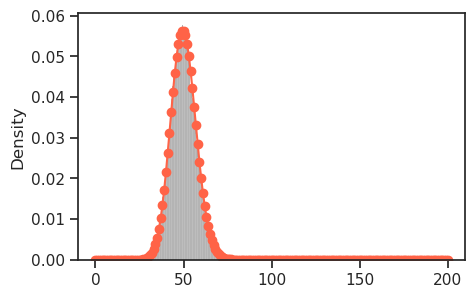

In [9]:
fig, ax = create_figure()
sns.histplot(samples_ga, color='dimgrey', stat='density', ax=ax)

x = range(int(4 * lamb) + 1)
ax.plot(x, po.pmf(x), color='tomato', marker='o')
plt.show()